<div class="alert alert-block alert-info">
<b>Deadline:</b> May 10, 2023 (Wednesday) 23:00
</div>

# Exercise 1. Denoising Diffusion Probabilistic Models (DDPM)

The goal of this exercise is to get familiar with diffusion-based generative models using the DDPM model as an example. The model is proposed in [this paper](https://arxiv.org/pdf/2006.11239.pdf).

**This exercise requires a significant amount of computing power, you need to use a GPU.**

In [65]:
skip_training = False  # Set this flag to True before validation and submission

In [66]:
# During evaluation, this cell sets skip_training to True
# skip_training = True
!pip install einops
import tools, warnings
warnings.showwarning = tools.customwarn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import fd

In [68]:

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'GPU {torch.cuda.get_device_name()} is available')
else:
    device = torch.device('cpu')
    print('No GPU available, using CPU instead')

GPU Tesla T4 is available


In [69]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [70]:
# Select the device for training (use GPU if you have one)
# device = torch.device('cpu')
device = torch.device('cuda:0')

In [71]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device('cpu')

# Data

In this exercise, we use standard MNIST data. To simplify the construction of the denoising model (U-net), we upscale the images to $32\times 32$ resolution.

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

#trainset = datasets.MNIST(root='../data/', train=True, download=True, transform=transform,)
trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

torch.Size([128, 1, 32, 32])


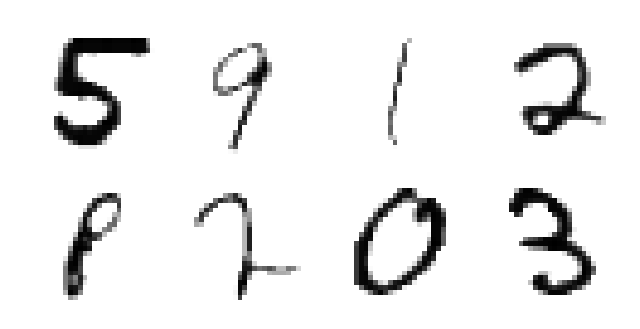

In [73]:
images, labels = next(iter(trainloader))
print(images.shape)
tools.show_images(images[:8], ncol=4, cmap='binary', clim=[0,1])

# Diffusion model

In DDPM, the forward process (or diffusion process) is a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule $\beta_1, ..., \beta_T$:
$$
q(x_{1:T} | x_0) = \prod^T_{t=1} q(x_t|x_{t−1}), q(x_t|x_{t−1}) = N (x_t; \sqrt{1 − \beta_t} x_{t−1}, \beta_t I)
$$

* In our implementation of DDPM, we use a linear schedule for $\beta_t$ that grows linearly from 0.0001 to 0.02 with T=1000 time steps in total. Please store the values of $\beta_t$ in attribute `self.betas`.

* We implement the forward diffusion process in function `forward()`. This function receives a clearn sample $x_0$ and a noise instance $\epsilon_t$ and returns
$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t
$$
which is a sample from the following distribution:
$$
q(x_t|x_0) = N(x_t; \sqrt{\bar{\alpha}_t} x_{0}, (1 - \bar{\alpha}_t) I)
$$
where
$$
\bar{\alpha}_t = \prod^t_{s=1} \alpha_s
\qquad
\alpha_t = 1 − \beta_t.
$$
Note that the denoising model is trained to predict the noise instance $\epsilon_t$ which is why we create it outside of the function.

* Samples are generated with an inverse diffusion process which we implement in function `sample()`. The sampling process is described in Algorithm 2 of the paper:
<img src="alg_sampling.png" width=350>
where $\sigma_t = \sqrt{\beta_t}$.

Notes:
* **In this exercise, we do not condition our generative model on the class information (the classes of digits). Therefore, we expect argument `labels` to be `None`. If you are interested in playing with a generative model conditioned on the class information, you can write your code to support this scenario. We expect no conditioning on classes in the grading tests.**

In [88]:
class Diffusion(nn.Module):
    """Diffusion model with a linear schedule of the temperatures.
    """
    def __init__(self, num_timesteps=1000):
        super(Diffusion, self).__init__()

        # YOUR CODE HERE
        # raise NotImplementedError()
        # In our implementation of DDPM, we use a linear schedule for $\beta_t$ that grows linearly from 0.0001 to 0.02 
        # with T=1000 time steps in total. Please store the values of $\beta_t$ in attribute `self.betas`.
        self.betas = torch.linspace(0.0001, 0.02, steps=num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)
        self.num_timesteps=1000
        
    def forward(self, x, t, noise=None):
        """
        Args:
          x of shape (batch_size, ...): Input samples.
          t of shape (batch_size,): Corruption temperatures.
          noise of shape (batch_size, ...): Noise instanses used for corruption.
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        # We implement the forward diffusion process in function forward(). This function receives a clean sample 𝑥0
        # and a noise instance 𝜖𝑡 and returns 𝑥𝑡=√𝛼¯𝑡 𝑥0 +√1−𝛼¯𝑡 𝜖𝑡
        if noise is None:
            noise = torch.randn_like(x)

        alphas_bar_t = self.alphas_bar[t]    
        alphas_bar_t = alphas_bar_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) 
        noised_x = torch.sqrt(alphas_bar_t) * x + torch.sqrt(1 - alphas_bar_t) * noise

        return noised_x

    @torch.no_grad()
    def sample(self, model, x_shape, labels=None):
        """
        Args:
          model: A denoising model. model(x, t, labels) takes as inputs:
                   x of shape (batch_size, n_channels, H, W): corrupted examples.
                   t of shape (batch_size,): LongTensor of time steps.
                   labels of shape (batch_size,): LongTensor of the classes of the examples in x.
                 and outputs a denoised version of input x.
          x_shape: The shape of the generated data. For example, to generate batch_size images of shape (1, H, W),
                   x_shape should be (batch_size, 1, H, W).
          labels of shape (batch_size,): LongTensor of the classes of generated samples. None for no conditioning
                   on classes.
        
        Note: Create new tensors on the same device where the model is.
        """
        # YOUR CODE HERE
        # raise NotImplementedError()

        x_t = torch.randn(x_shape, device=device)     
        
        batch_size = x_shape[0]
        # Sample from diffusion process
        T = self.betas.shape[0]
        for t in range(T, 0, -1):
            if t != 1:
                z = torch.randn(x_shape, device=device)
            else:
                z = torch.zeros(x_shape, device=device)
            index = t - 1
            beta_t = self.betas[index]
            alpha_t = self.alphas[index]
            alpha_bar_t = self.alphas_bar[index]
            t_tensor = torch.full((batch_size,), t)
            eta_theta = model.forward(x_t, torch.full((batch_size,), t).to(device), labels=labels) 
            x_t = 1/torch.sqrt(alpha_t) * (x_t - (1-alpha_t)/(torch.sqrt(1-alpha_bar_t)) * eta_theta) + torch.sqrt(beta_t) * z
            
        # Return final samples
        return x_t

In [75]:
diffusion = Diffusion(1000)
assert diffusion.betas[0] == 1e-4, "The lowest temperature should be 1e-4"
assert diffusion.betas[-1] == 0.02, "The highest temperature should be 0.02"
assert len(diffusion.betas) == 1000, "The number of steps should be 1000"

def test_diffusion_forward_shapes():
    diffusion = Diffusion(1000)
    batch_size = 2
    x = torch.randn(batch_size, 1, 32, 32)
    t = torch.LongTensor([500, 900])
    
    out = diffusion.forward(x, t)
    assert out.shape == x.shape, f"Bad out.shape: {out.shape}"

    noise = torch.randn_like(x)
    out = diffusion.forward(x, t, noise)
    assert out.shape == x.shape, f"Bad out.shape: {out.shape}"
    print('Success')

test_diffusion_forward_shapes()

Success


In [76]:
def test_diffusion_forward():
    diffusion = Diffusion(1000)
    batch_size = 2
    x = 2 * torch.ones(batch_size, 1, 32, 32)
    t = torch.LongTensor([500, 900])
    noise = torch.ones_like(x)
    out = diffusion.forward(x, t, noise)
    expected = torch.empty_like(x)
    expected[0].fill_(1.51815533)
    expected[1].fill_(1.03274309)

    print('out:\n', out)
    print('expected correct:\n', expected)
    assert torch.allclose(expected, out), "out does not match the expected value."
    print('Success')

out = test_diffusion_forward()

out:
 tensor([[[[1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          ...,
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182]]],


        [[[1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          ...,
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327]]]])
expected correct:
 tensor([[[[1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5

In [77]:
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, t, labels=None):
        return x

def test_diffusion_sample_shapes():
    diffusion = Diffusion(1000)
    batch_size = 2
    x_shape = (batch_size, 1, 32, 32)
    model = DummyModel()
    
    out = diffusion.sample(model, x_shape, labels=None)
    assert out.shape == x_shape, f"Bad out.shape: {out.shape}"
    print('Success')

test_diffusion_sample_shapes()

Success


In [78]:
import unittest.mock

def my_randn_like(x):
    return torch.ones_like(x)

def my_randn(*args, **kwargs):
    return torch.ones(*args, **kwargs)

def my_normal(mean, std, **kwargs):
    return mean + std * torch.ones_like(std)

@unittest.mock.patch('torch.randn_like', my_randn_like)
@unittest.mock.patch('torch.randn', my_randn)
@unittest.mock.patch('torch.normal', my_normal)
def test_diffusion_sample():
    diffusion = Diffusion(10)
    model = DummyModel()
    batch_size = 2
    x_shape = (batch_size, 1, 32, 32)

    out = diffusion.sample(model, x_shape, labels=None)
    expected = torch.empty(x_shape).fill_(1.3058254)
    print('out:\n', out)
    print('expected correct:\n', expected)
    assert torch.allclose(expected.to(device), out), "out does not match the expected value."
    print('Success')

test_diffusion_sample()

out:
 tensor([[[[1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          ...,
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058]]],


        [[[1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          ...,
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058]]]],
       device='cuda:0')
expected correct:
 tensor([[[[1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058,

We can visualize the forward process in the cell below. Note that since `Diffusion.forward()` samples independent noise instances for different time steps $t$, the illustration below does **not** correspond to steps of the same diffusion process.

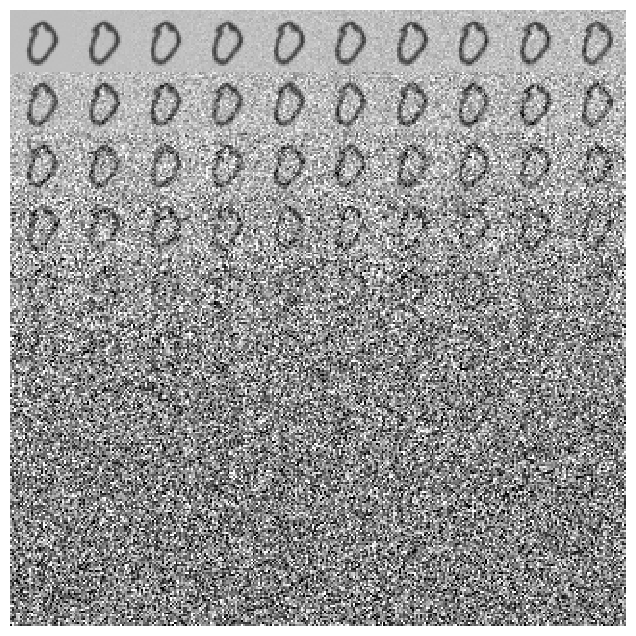

In [79]:
diffusion = Diffusion(1000)
t = torch.arange(0, diffusion.num_timesteps, 10)
x, _ = random.choice(trainset)
x = x[None, ...].tile(len(t), 1, 1, 1)  # (t_steps, c, h, w)

x_perturbed = diffusion.forward(x, t)
tools.show_images(x_perturbed, ncol=10, cmap='binary', clim=[-2, 2])

## Construct the denoising model

A denoising model is the model that predicts the noise instance $\epsilon$
$$
  \epsilon = f(\tilde{x}, t, y)
$$
that was used to generate the corrupted sample $\tilde{x}$ with the corruption level defined by time step $t$. For denoising conditioned on label $y$, the model additionally accepts the label information $y$ (optional). 

The output $\epsilon$ of the model should have the same dimensionality as the input $\tilde{x}$. The architecture that is very commonly used for $f$ is a U-net.

We are not testing the architecture of the U-net in this notebook but the following architecture worked for us:
* The model uses blocks `ResidualBlock`, `Downsample` and `PositionalEmbedding` defined in `blocks.py`.
* To enable conditioning on time step $t$, we encode the time step using an MLP that is a sequence of the following layers:
  * `PositionalEmbedding` with `base_channels` outputs
  * `Linear` layer with `time_emb_dim` outputs
  * `SiLU` nonlinearity
  * `Linear` layer with `time_emb_dim` outputs
  
* The encoder is a sequence of the following blocks:
  * A convolutional layer with 3x3 kernel, `base_channels` output channels, which keeps the resolution of the input.
  * `ResidualBlock` with `base_channels` output channels.
  * `Downsample` layer which preserves the number of channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Downsample` layer which preserves the number of channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Downsample` layer which preserves the number of channels.
  * `ResidualBlock` with `2*base_channels` output channels.

* The encoder is followed by a bottleneck layer which is
  * `ResidualBlock` with `2*base_channels` output channels.
  
* The decoder is a sequence of the following blocks:
  * `ResidualBlock` with `2*base_channels` output channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Upsample` layer which preserves the number of channels.

  * `ResidualBlock` with `2*base_channels` output channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Upsample` layer which preserves the number of channels.

  * `ResidualBlock` with `2*base_channels` output channels.
  * `ResidualBlock` with `base_channels` output channels.
  * `Upsample` layer which preserves the number of channels.

  * `ResidualBlock` with `base_channels` output channels.
  * `ResidualBlock` with `base_channels` output channels.
  * A convolutional layer with 3x3 kernel, `img_channels` output channels, which keeps the resolution of the input.
  
**Notes:**

* Each residual block receives the time-step embedding produced by the MLP defined above and the label of a sample as extra inputs.
  
* The inputs of the decoder residual blocks are concatenations of two signals: the output of the previous decoder layer and the skip signal produced by the corresponding layer of the encoder.

* There are 8 skip signals in totals: they are the outputs of the first convolutional layer and the encoder blocks of type `ResidualBlock` and `Downsample`.

* `Upsample` layers of the decoder do not receive skip signals.

* **In this exercise, we do not condition our generative model on the class information (the classes of digits). Therefore, we expect argument `num_classes` to be `None`. If you are interested in playing with a generative model conditioned on the class information, you can write your code to support this scenario. We expect no conditioning on classes in the grading tests.**

In [100]:
from blocks import ResidualBlock, Downsample, Upsample, PositionalEmbedding


class UNet(nn.Module):
    """The denoising model.
    
    Args:
      img_channels (int): Number of image channels.
      base_channels (int): Number of base channels.
      time_emb_dim (int or None): The size of the embedding vector produced by the MLP which embeds the time input.
      num_classes (int or None): Number of classes, None for no conditioning on classes.
    """

    def __init__(self, img_channels, base_channels, time_emb_dim=None, num_classes=None):
        # YOUR CODE HERE
        # raise NotImplementedError()
        super(UNet, self).__init__()
        self.time_emb_dim = time_emb_dim
        self.num_classes = num_classes

        # To enable conditioning on time step $t$, we encode the time step using an MLP that is a sequence of the 
        # following layers:
        # `PositionalEmbedding` with `base_channels` outputs
        # `Linear` layer with `time_emb_dim` outputs
        # `SiLU` nonlinearity
        # `Linear` layer with `time_emb_dim` outputs
        
        # Time embedding MLP
        if time_emb_dim is not None:
            self.positional_encoding = nn.Sequential(
                PositionalEmbedding(dim=base_channels),
                nn.Linear(in_features=base_channels, out_features=time_emb_dim),
                nn.SiLU(),
                nn.Linear(in_features=time_emb_dim, out_features=time_emb_dim),
            )
        else:
            self.positional_encoding = None
            
        # The encoder is a sequence of the following blocks:
        # A convolutional layer with 3x3 kernel, `base_channels` output channels, which keeps the resolution of the input.
        # `ResidualBlock` with `base_channels` output channels.
        # `Downsample` layer which preserves the number of channels.
        # `ResidualBlock` with `2*base_channels` output channels.
        # `Downsample` layer which preserves the number of channels.
        # `ResidualBlock` with `2*base_channels` output channels.
        # `Downsample` layer which preserves the number of channels.
        # `ResidualBlock` with `2*base_channels` output channels.
        
        self.encoder_conv0 = nn.Conv2d(in_channels = img_channels, out_channels = base_channels, kernel_size = 3, stride = 1, padding = 1)

        self.encoder_rb1 = ResidualBlock(in_channels = base_channels, out_channels = base_channels, time_emb_dim = time_emb_dim, num_classes = num_classes)
        
        self.encoder_ds1 = Downsample(in_channels = base_channels)
        
        self.encoder_rb2 = ResidualBlock(in_channels = base_channels, out_channels = base_channels * 2, time_emb_dim = time_emb_dim, num_classes = num_classes)
        
        self.encoder_ds2 = Downsample(in_channels = base_channels * 2)
        
        self.encoder_rb3 = ResidualBlock(in_channels = base_channels * 2, out_channels = base_channels * 2, time_emb_dim = time_emb_dim, num_classes = num_classes)
        
        self.encoder_ds3 = Downsample(in_channels = base_channels * 2)

        self.encoder_rb4 = ResidualBlock(in_channels = base_channels * 2, out_channels = base_channels * 2, time_emb_dim = time_emb_dim, num_classes = num_classes)
        
        # The encoder is followed by a bottleneck layer which is
        # `ResidualBlock` with `2*base_channels` output channels.

        self.encoder_bottleneck_rb = ResidualBlock(in_channels = base_channels * 2, out_channels = base_channels * 2, time_emb_dim = time_emb_dim, num_classes = num_classes)


        # * The decoder is a sequence of the following blocks:
        # * `ResidualBlock` with `2*base_channels` output channels.
        # * `ResidualBlock` with `2*base_channels` output channels.
        # * `Upsample` layer which preserves the number of channels.

        # * `ResidualBlock` with `2*base_channels` output channels.
        # * `ResidualBlock` with `2*base_channels` output channels.
        # * `Upsample` layer which preserves the number of channels.

        # * `ResidualBlock` with `2*base_channels` output channels.
        # * `ResidualBlock` with `base_channels` output channels.
        # * `Upsample` layer which preserves the number of channels.

        # * `ResidualBlock` with `base_channels` output channels.
        # * `ResidualBlock` with `base_channels` output channels.
        # * A convolutional layer with 3x3 kernel, `img_channels` output channels, which keeps the resolution of the input.
        
        # Decoding path
        self.decoder_rb1 = ResidualBlock(in_channels = base_channels * 4, out_channels = base_channels * 2, time_emb_dim = time_emb_dim, num_classes = num_classes)
        self.decoder_rb2 = ResidualBlock(in_channels = base_channels * 4, out_channels = base_channels * 2, time_emb_dim = time_emb_dim, num_classes = num_classes)
        self.decoder_us1 = Upsample(in_channels = base_channels * 2)
        
        self.decoder_rb3 = ResidualBlock(in_channels = base_channels * 4, out_channels = base_channels * 2, time_emb_dim = time_emb_dim, num_classes = num_classes)
        self.decoder_rb4 = ResidualBlock(in_channels = base_channels * 4, out_channels = base_channels * 2, time_emb_dim = time_emb_dim, num_classes = num_classes)
        self.decoder_us2 = Upsample(in_channels = base_channels * 2)
        
        self.decoder_rb5 = ResidualBlock(in_channels = base_channels * 4, out_channels = base_channels * 2, time_emb_dim = time_emb_dim, num_classes = num_classes)
        self.decoder_rb6 = ResidualBlock(in_channels = base_channels * 3, out_channels = base_channels, time_emb_dim = time_emb_dim, num_classes = num_classes)
        self.decoder_us3 = Upsample(in_channels = base_channels)
        
        self.decoder_rb7 = ResidualBlock(in_channels = base_channels * 2, out_channels = base_channels, time_emb_dim = time_emb_dim, num_classes = num_classes)
        self.decoder_rb8 = ResidualBlock(in_channels = base_channels * 2, out_channels = base_channels, time_emb_dim = time_emb_dim, num_classes = num_classes)
        self.decoder_conv4 = nn.Conv2d(in_channels = base_channels, out_channels = img_channels, kernel_size=3, stride = 1, padding=1)


            
    def forward(self, x, time=None, labels=None):
        """Estimate noise instances used to produced corrupted examples `x` with the corruption level determined
        by `time`. `labels` contains the class information of the examples in `x`.

        Args:
          x of shape (batch_size, n_channels, H, W): Corrupted examples.
          time of shape (batch_size,): LongTensor of time steps which determine the corruption level for
                                       the examples in x.
          labels of shape (batch_size,): LongTensor of the classes of the examples in x.
        
        Returns:
          out of shape (batch_size, n_channels, H, W)
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        
        # Encoding path
        #print(time.device)
        time_encoded = time

        if self.positional_encoding is not None:
            time_encoded = self.positional_encoding(time)
        
        # Each residual block receives the time-step embedding produced by the MLP defined above and the 
        # label of a sample as extra inputs. 
        
        # y = x.clone().to(device)
        
        # There are 8 skip signals in totals: they are the outputs of the first convolutional layer and the encoder blocks
        # of type `ResidualBlock` and `Downsample`.
        skip_connections = []
        
        y = self.encoder_conv0(x)
        skip_connections.append(y) # 1st skip

        y = self.encoder_rb1(y, time_encoded, y=labels)
        skip_connections.append(y) # 2nd skip
        
        y = self.encoder_ds1(y)
        skip_connections.append(y) # 3rd skip
        
        y = self.encoder_rb2(y, time_encoded, y=labels)
        skip_connections.append(y) # 4th skip
        
        y = self.encoder_ds2(y)
        skip_connections.append(y) # 5th skip
        
        y = self.encoder_rb3(y, time_encoded, y=labels)
        skip_connections.append(y) # 6th skip
        
        y = self.encoder_ds3(y)
        skip_connections.append(y) # 7th skip

        y = self.encoder_rb4(y, time_encoded, y=labels)
        skip_connections.append(y) # 8th skip
        
        y = self.encoder_bottleneck_rb(y, time_encoded, y=labels)

        # Reversing the skip connections
        # 1st closest to bottleneck in encoder corresponds to 1st closest to bottle neck in decoder and so on
        skip_connections = list(reversed(skip_connections))
        
        # Decoding path
        
        # The inputs of the decoder residual blocks are concatenations of two signals: 
        # the output of the previous decoder layer and the skip signal produced by the corresponding layer of the encoder.
        
        y = torch.cat([y, skip_connections[0]], dim = 1)
        y = self.decoder_rb1(y, time_encoded, y=labels)
        
        y = torch.cat([y, skip_connections[1]], dim = 1)
        y = self.decoder_rb2(y, time_encoded, y=labels)
        
        # `Upsample` layers of the decoder do not receive skip signals.
        y = self.decoder_us1(y)
        
        y = torch.cat([y, skip_connections[2]], dim = 1)
        y = self.decoder_rb3(y, time_encoded, y=labels)
        
        y = torch.cat([y, skip_connections[3]], dim = 1)
        y = self.decoder_rb4(y, time_encoded, y=labels)
        
        y = self.decoder_us2(y)
        
        y = torch.cat([y, skip_connections[4]], dim = 1)
        y = self.decoder_rb5(y, time_encoded, y=labels)
        
        y = torch.cat([y, skip_connections[5]], dim = 1)
        y = self.decoder_rb6(y, time_encoded, y=labels)
        
        y = self.decoder_us3(y)
        
        y = torch.cat([y, skip_connections[6]], dim = 1)
        y = self.decoder_rb7(y, time_encoded, y=labels)
        
        y = torch.cat([y, skip_connections[7]], dim = 1)
        y = self.decoder_rb8(y, time_encoded, y=labels)

        y = self.decoder_conv4(y)
        
        return y

In [101]:
def test_UNet_shapes():
    unet = UNet(
        img_channels=1,
        base_channels=128,
        time_emb_dim=32,
        num_classes=None,
    ).to(device)

    batch_size = 3
    x = torch.randn(batch_size, 1, 32, 32)
    t = torch.LongTensor([0, 1, 2])
    labels = None
    out = unet(x.to(device), t.to(device), labels)
    assert out.shape == x.shape, f"Bad out.shape: {out.shape}"
    print('Success')

test_UNet_shapes()

Success


## Train the model

Implement the training loop in the cell below.

The training procedure consists of the following steps for each mini-batch:
* Sample uniformly time steps from 0 to `Diffusion.num_timesteps-1` for each training example.
* Compute corrupted samples with `Diffusion.forward`.
* Estimate the noise used to generate the corrupted samples with the U-net model.
* The loss is the MSE loss between the estimated noise and the ground-truth noise.

The implementation should follow Algorithm 1 of the paper:
<img src="alg_training.png" width=350>


The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 20. If you train longer, the quality of the generated samples should increase further.

Hints:
- The loss at convergence should reach 0.017 after about 11 epochs. We check that the loss is below 0.02 in the grading tests.
- You can track the training progress by plotting 120 generated samples and computing the FD score using the code below
```python
fdscore = fd.FDScore.pretrained(imsize=32)
fdscore.to(device)
...
with torch.no_grad():
    model.eval()
    x_shape = (120, 1, 32, 32)
    samples = diffusion.sample(model, x_shape)
    score = fdscore.calculate(samples)

    samples = ((samples + 1) / 2).clip(0, 1)
    tools.show_images(samples, cmap='binary', ncol=10)

    print(f'FD score: {score:.5f}')
```
- The FD score should be below 2 at convergence. We check that is below 3.5 in the grading tests.
- **Do not forget to set the model into the training mode by `net.train()` before training.**
- The generated samples are expected to look similar to this:
<img src="diffusion_samples.png" width=400>

In [102]:
# Create a model
diffusion = Diffusion(1000)
model = UNet(
    img_channels=1,
    base_channels=32,
    time_emb_dim=32,
    num_classes=None,
)

diffusion.to(device);
model.to(device);

# Move all attributes of diffusion to the device
diffusion.alphas_bar = diffusion.alphas_bar.to(device)
diffusion.alphas = diffusion.alphas.to(device)
diffusion.betas = diffusion.betas.to(device)


print(diffusion.alphas_bar.device)
print(diffusion.alphas.device)
print(diffusion.betas.device)

cuda:0
cuda:0
cuda:0


Epoch 1, Loss: 0.0272


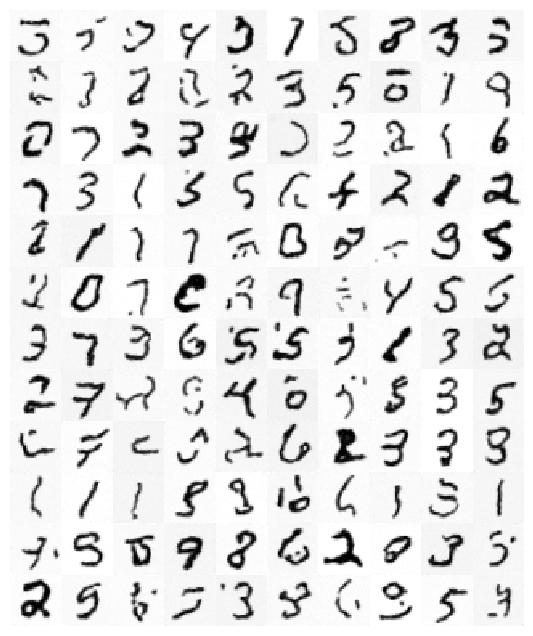

FD score: 4.60091
Epoch 2, Loss: 0.0220


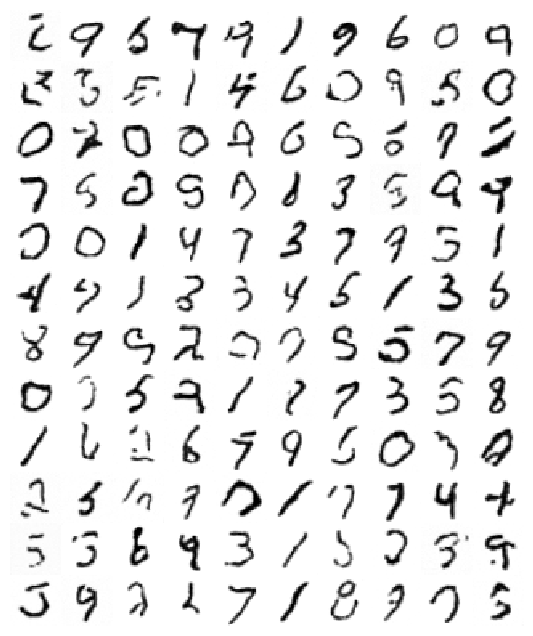

FD score: 3.65799
Epoch 3, Loss: 0.0204


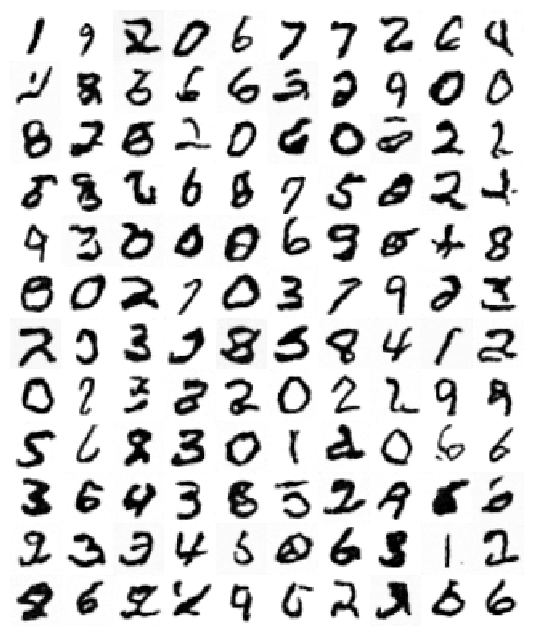

FD score: 2.99755
Epoch 4, Loss: 0.0195


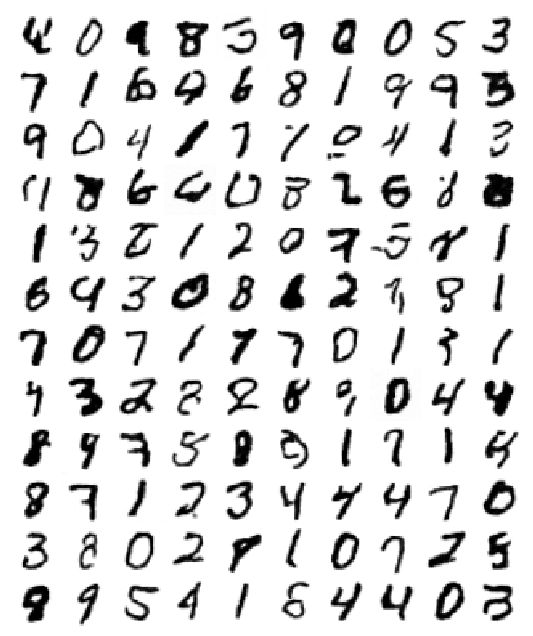

FD score: 1.96459
Epoch 5, Loss: 0.0189


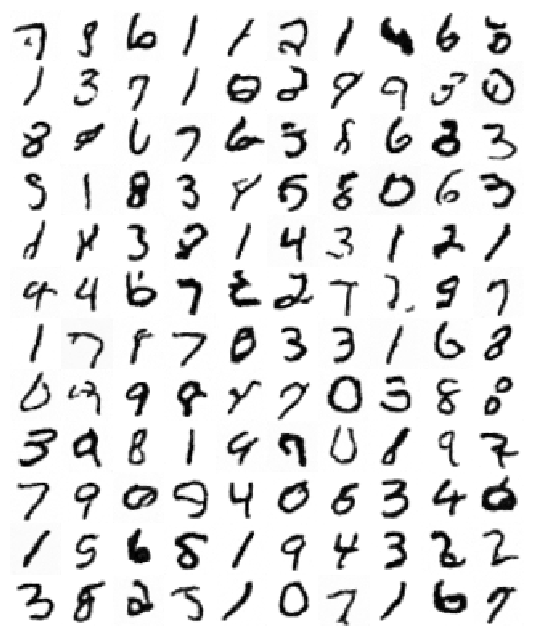

FD score: 1.05850
Epoch 6, Loss: 0.0184


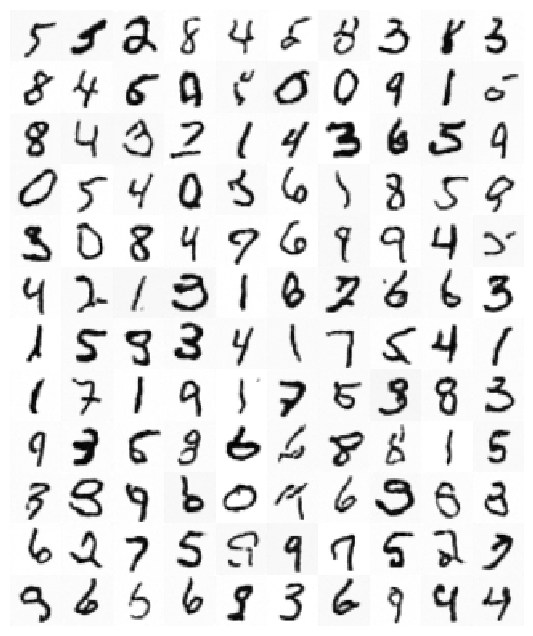

FD score: 1.88004
Epoch 7, Loss: 0.0181


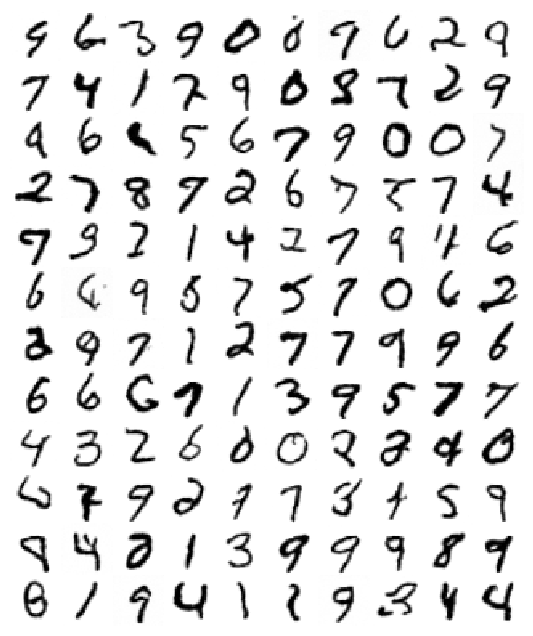

FD score: 2.69140
Epoch 8, Loss: 0.0181


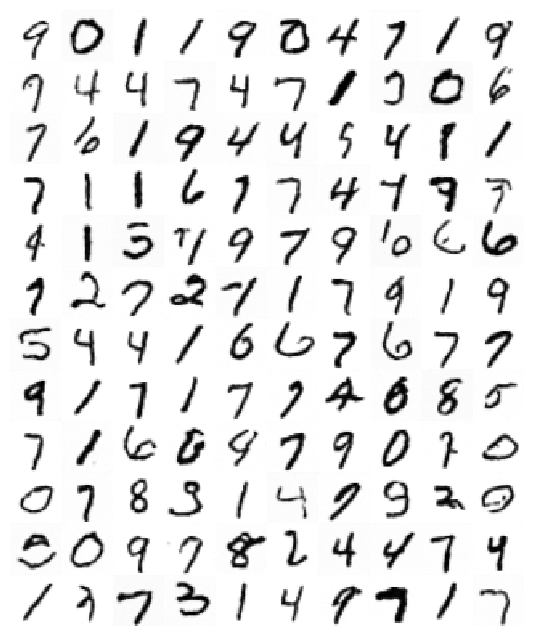

FD score: 4.95995
Epoch 9, Loss: 0.0178


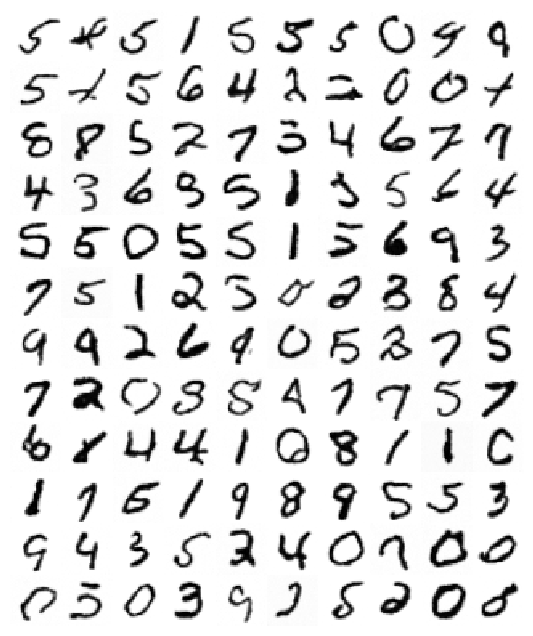

FD score: 2.01969
Epoch 10, Loss: 0.0177


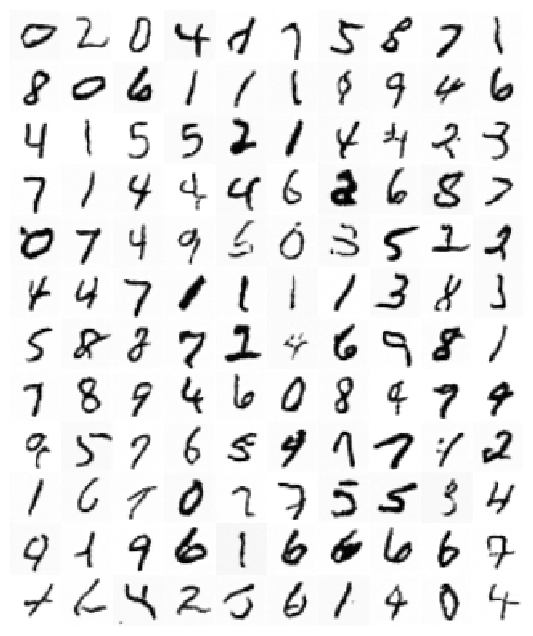

FD score: 2.09946
Epoch 11, Loss: 0.0173


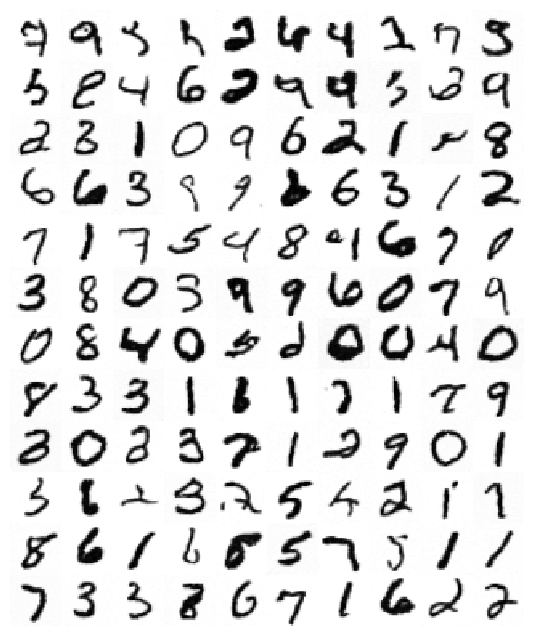

FD score: 1.10085
Epoch 12, Loss: 0.0173


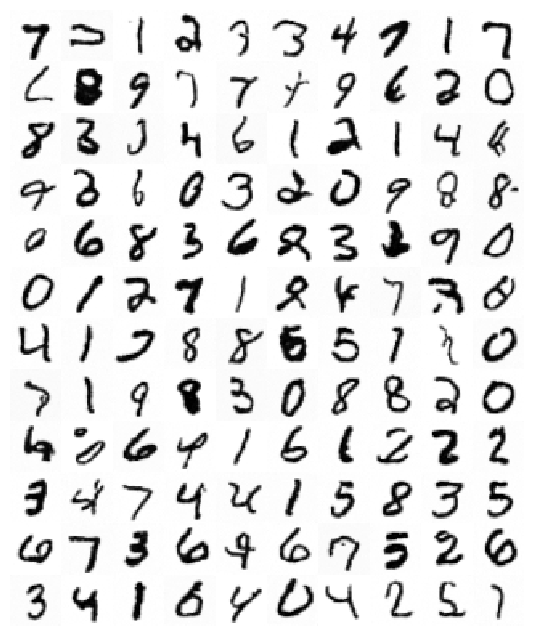

FD score: 0.82792
Epoch 13, Loss: 0.0173


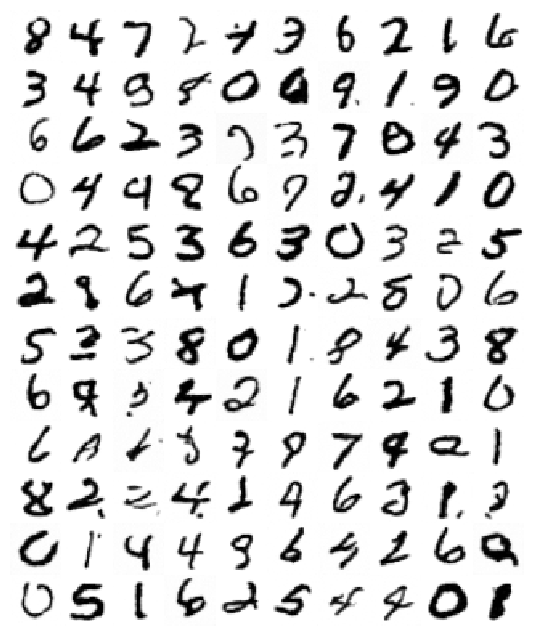

FD score: 1.40996
Epoch 14, Loss: 0.0172


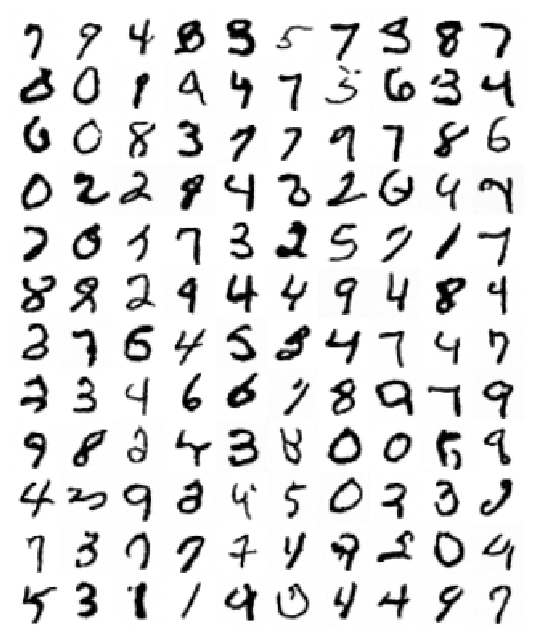

FD score: 2.67520
Epoch 15, Loss: 0.0170


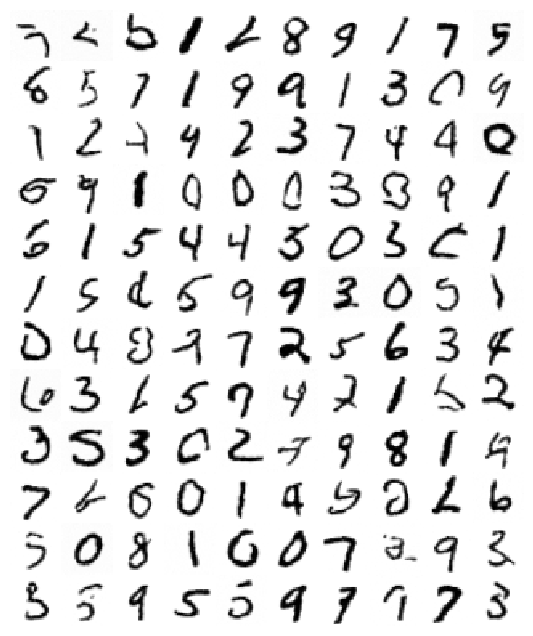

FD score: 1.96513
Epoch 16, Loss: 0.0170


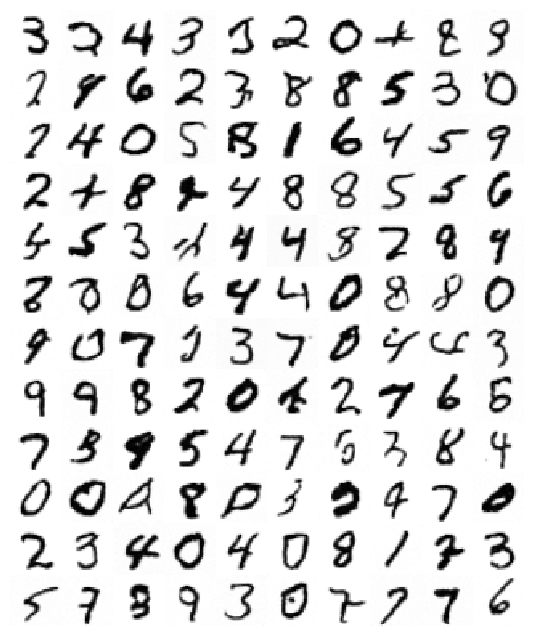

FD score: 2.07608
Epoch 17, Loss: 0.0170


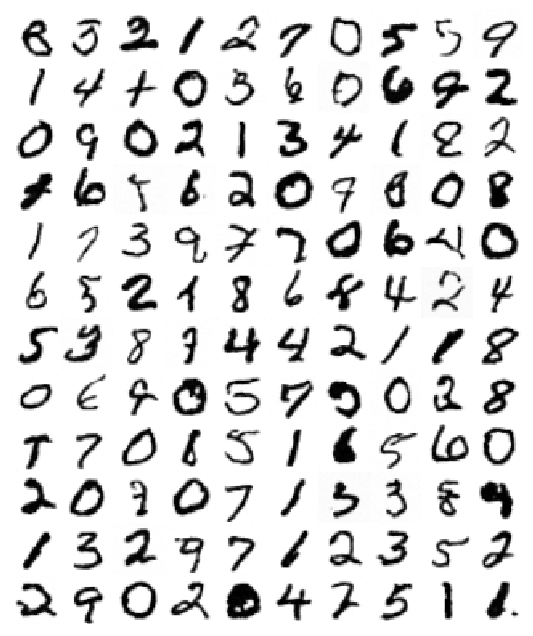

FD score: 1.29932
Epoch 18, Loss: 0.0167


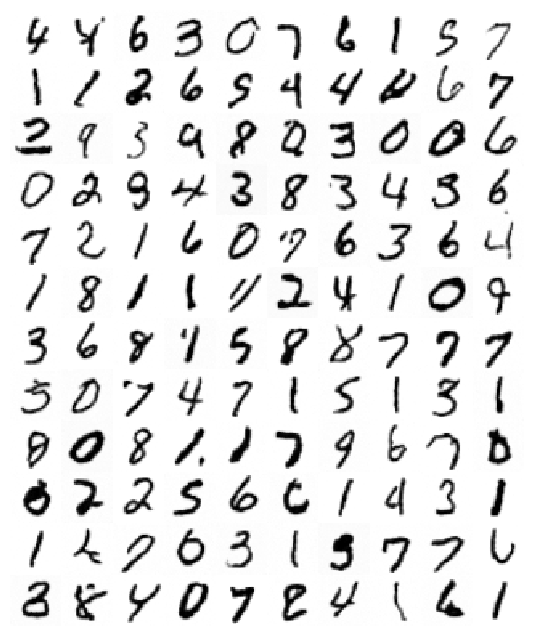

FD score: 1.74608
Epoch 19, Loss: 0.0168


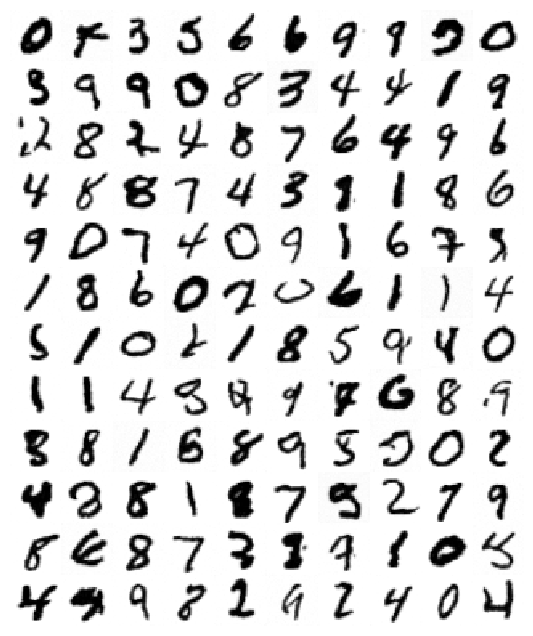

FD score: 1.84382
Epoch 20, Loss: 0.0168


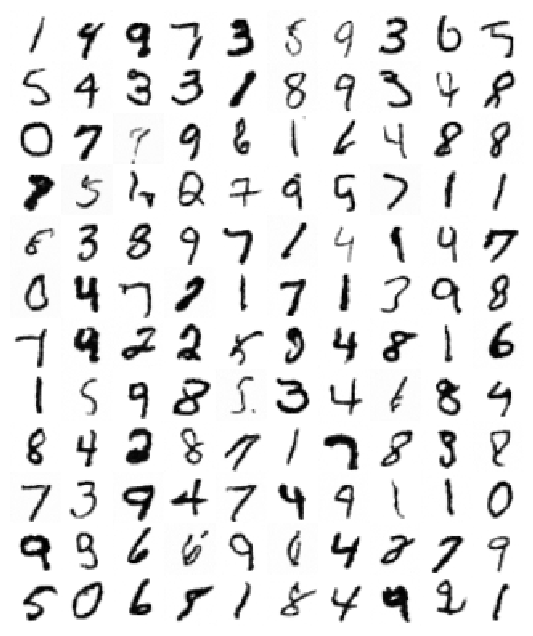

FD score: 2.06005
Finished Training


In [104]:
import torch.optim as optim

if not skip_training:
    # YOUR CODE HERE
    # raise NotImplementedError()

    criterion = nn.MSELoss()
    
    # Adam optimizer with learning rate 0.001
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    # Training loop
    # Number of epochs: 20. If you train longer, the quality of the generated samples should increase further
    for epoch in range(20):

        train_loss = []
        
        # Do not forget to set the model into the training mode by net.train() before training
        model.train()
        
        # The training procedure consists of the following steps for each mini-batch:

        for i, data in enumerate(trainloader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            batch_size = images.shape[0]
    
            # Sample uniformly random time steps from 0 to `Diffusion.num_timesteps-1` for each training example.
            timesteps = torch.randint(0, diffusion.num_timesteps, (batch_size,)).to(device)

            # Apply forward diffusion process at the given timestep
            # Compute corrupted samples with `Diffusion.forward`.
            # print(timesteps.device)
            # print(images.device)
            ground_noise = torch.randn(images.shape).to(device)

            noisy_images = diffusion.forward(x = images, t = timesteps, noise = ground_noise)
            noisy_images = noisy_images.to(device)

            # Predict the noise residual
            # Estimate the noise used to generate the corrupted samples with the U-net model.
            # In this exercise, we do not condition our generative model on the class information (the classes of digits). 
            # Therefore, we expect argument labels to be None. If you are interested in playing with a generative model conditioned on the class information, you can write your code to support this scenario. We expect no conditioning on classes in the grading tests.
            
            pred_noise = model(x = noisy_images, time = timesteps, labels = None)
            
            # The loss is the MSE loss between the estimated noise and the ground-truth noise.
            
            loss = criterion(pred_noise, ground_noise)
            
            # The loss at convergence should reach 0.017 after about 11 epochs. 
            # We check that the loss is below 0.02 in the grading tests.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss.append(loss.item())
            #print(train_loss[-1])
            
        loss = np.mean(train_loss)
        print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')
        
        # The FD score should be below 2 at convergence. We check that is below 3.5 in the grading tests.
        fdscore = fd.FDScore.pretrained(imsize=32)
        fdscore.to(device)
        
        with torch.no_grad():
            model.eval()
            x_shape = (120, 1, 32, 32)
            samples = diffusion.sample(model, x_shape)
            score = fdscore.calculate(samples)

            samples = ((samples + 1) / 2).clip(0, 1)
            tools.show_images(samples, cmap='binary', ncol=10)

            print(f'FD score: {score:.5f}')
        
    print('Finished Training')

In [105]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(diffusion, '1_diffusion.pth', confirm=False)
    tools.save_model(model, '1_unet.pth', confirm=False)

Model saved to 1_diffusion.pth.
Model saved to 1_unet.pth.


In [ ]:
if skip_training:
    diffusion = Diffusion(1000)
    model = UNet(
        img_channels=1,
        base_channels=32,
        time_emb_dim=32,
        num_classes=None,
    )
    
    tools.load_model(diffusion, '1_diffusion.pth', device)
    tools.load_model(model, '1_unet.pth', device)

### Generate samples

In [ ]:
# Save generated samples (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    with torch.no_grad():
        x_shape = (120, 1, 32, 32)
        samples = diffusion.sample(model, x_shape)
        torch.save(samples, '1_samples.pth')
else:
    samples = torch.load('1_samples.pth', map_location=lambda storage, loc: storage)

fdscore = fd.FDScore.pretrained(imsize=32)
fdscore.to(device)
score = fdscore.calculate(samples)
print('FD score:', score)
assert score < 3.5, 'The FD score should be below 3.5'
print('Success')

In [ ]:
samples01 = ((samples + 1) / 2).clip(0, 1)
tools.show_images(samples01, cmap='binary', ncol=10)

In [ ]:
# This cell tests the training loss of the trained denoising model

## In-painting: Conditional generation given known parts of a generated image

One of the benefits of diffusion-based generative model is the possibility to use a trained model for *conditional* generation of some parts (of an image) given known values of other parts. For example, given the top part of an image (like in the images shown below)
<img src="conditioning.png" width=400>
the model can generate samples which have the given values in the top part:
<img src="cond_samples.png" width=400>

In the cell below, your need to implement a function that generate samples conditioned on known parts of samples using your trained diffusion model.

Hints:
* There are different ways of performing this task but the most straightforward implementation contains a single for-loop similar to the standard reverse-diffusion process. The only difference is that the pixels of the known parts should converge to the known values by using an appropriate distribution to draw samples from.

* We recommend you to figure out the required math from [the original DDPM paper](https://arxiv.org/pdf/2006.11239.pdf).

* **In this exercise, we do not condition our generative model on the class information (the classes of digits). Therefore, we expect argument `labels` to be `None`. If you are interested in playing with a generative model conditioned on the class information, you can write your code to support this scenario. We expect no conditioning on classes in the grading tests.**


In [ ]:
@torch.no_grad()
def inpaint(diffusion, model, images, mask_known, labels=None):
    """Generate samples conditioned on known parts of images.
    
    Args:
      diffusion (Diffusion): The descriptor of a diffusion model.
      model: A denoising model: model(x, t, labels) outputs a denoised version of input x.
      images of shape (batch_size, n_channels, H, W): Conditioning images.
      mask_known of shape (batch_size, 1, H, W): BoolTensor which specifies known pixels in images (marked as True).
      labels of shape (batch_size,): Classes of images, None for no conditioning on classes.
    
    Returns:
      x of shape (batch_size, n_channels, H, W): Generated samples (one sample per input image).
    """
    batch_size, n_channels, H, W = images.shape
    assert mask_known.shape == (batch_size, 1, H, W)

    x_shape = (batch_size, n_channels, H, W)
    x = torch.randn(x_shape, device=images.device)
    x[mask_known] = images[mask_known]

    for t in reversed(range(diffusion.num_timesteps)):
        noise = torch.randn(x_shape, device=images.device)
        alpha = diffusion.get_alpha(t, x.device)

        x_cond = x.clone()
        x_cond[~mask_known] = 0  # Zero out unknown pixels
        x_cond.clamp_(-1, 1)

        x = x * alpha.sqrt() + (1 - alpha.sqrt()) * (x_cond + model(noise, t, labels) * (1 - alpha).sqrt())
        x = diffusion.perturb(x, t)

    return x
    # YOUR CODE HERE
    # raise NotImplementedError()

In [ ]:
# This script uses your function to perform conditional generation
if not skip_training:
    with torch.no_grad():
        #(images, labels) = next(iter(trainloader))
        image, label = trainset[4]  # Select one image from the dataset
        images = image[None, 0].tile(120, 1, 1, 1)  # Copy the image to generate multiple samples
        images = images.to(device)
        labels = None
        (batch_size, _, H, W) = images.shape

        # mask out the bottom part of every image
        mask_known = torch.zeros(batch_size, 1, H, W, dtype=torch.bool, device=device)
        mask_known[:, :, :H//2, :] = 1
        images_known = images * mask_known

        samples01 = ((images_known + 1) / 2).clip(0, 1)
        print('Conditioning:')
        tools.show_images(samples01[:120], cmap='binary', ncol=12)

        samples = inpaint(diffusion, model, images_known, mask_known, labels=None)
        samples01 = ((samples + 1) / 2).clip(0, 1)
        tools.show_images(samples01[:120], cmap='binary', ncol=12)

In [ ]:
@torch.no_grad()
def test_fid_score_inpaint(diffusion, model):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False)
    
    (images, labels) = next(iter(trainloader))
    images = images.to(device)
    labels = None
    (batch_size, _, H, W) = images.shape

    # mask out the bottom part of every image
    mask_known = torch.zeros(batch_size, 1, H, W, dtype=torch.bool, device=device)
    mask_known[:, :, :H//2, :] = 1
    images_known = images * mask_known

    if not skip_training:
        model.eval()
        samples = inpaint(diffusion, model, images_known, mask_known, labels=None)
        torch.save(samples, '1_cond_samples.pth')

    else:
        samples = torch.load('1_cond_samples.pth', map_location=lambda storage, loc: storage)

    # Check conditioning
    mse = (samples - images)[mask_known].square().mean().item()
    print('MSE:', mse)
    assert mse < 1e-5, 'The known pixels should not change.'
    
    fdscore = fd.FDScore.pretrained(imsize=32)
    fdscore.to(device)
    score = fdscore.calculate(samples)
    print('FD score:', score)
    assert score < 3.5, 'The FD score should be below 3.5.'
    print('Success')

test_fid_score_inpaint(diffusion, model)

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this exercise, we trained a diffusion-based generative model and learned how to use the trained model for image in-painting.